### Library install :
- Python : `3.6`
- `conda install numpy`
- `conda install matplotlib`
- `conda install pandas`
- `conda instal scikit-learn`
- Opsi Tensorflow (**pilih salah satu**) :
    - `pip install tensorflow-gpu==1.12 --user` --> TF GPU | CUDA 9.0 | CuDNN 7.0 | GPU Driver Ver >= 385.xx
    - `pip install tensorflow-gpu==2.1 --user` --> TF GPU | CUDA 10.0 | CuDNN 7.6 | GPU Driver Ver >= 411.xx
    - `pip install tensorflow==2.1 --user` --> TF CPU
- `conda install keras`
- `conda install -c conda-forge ipykernel`

# Load dataset

In [1]:
import os
# if GPU is not available, just disable GPU 
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

dataset_folder = 'dataset/'
filenames = []
for filename in os.listdir(dataset_folder):
        filenames.append(filename)

In [2]:
filenames

['balanced_mitbih_train.csv',
 'ECG-01-C1-15-10-2020-14-47(Nicol).csv',
 'ECG-01-C2-15-10-2020-14-47(Nicol).csv',
 'ECG-01-C3-15-10-2020-14-47(Nicol).csv',
 'mitbih_test.csv',
 'mitbih_train.csv']

In [3]:
# check available GPU
import tensorflow as tf

# tensorflow  2.x 
#tf.config.list_physical_devices('GPU') 

# tensorflow 1.x
with tf.Session() as sess:
    print(sess.list_devices())

[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 12101135551417658684), _DeviceAttributes(/job:localhost/replica:0/task:0/device:GPU:0, GPU, 1502406247, 9001809502129287476)]


In [4]:
tf.__version__

'1.12.0'

In [5]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [6]:
train_df=pd.read_csv(dataset_folder + 'balanced_mitbih_train.csv',header=None)
test_df=pd.read_csv(dataset_folder + 'mitbih_test.csv',header=None)

## Dataset MIT-BIH
Dataset MIT-BIH terdiri dari 188 kolom, dimana kolom ke 188 merupakan katerori/class.

In [7]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.162791,0.540698,0.755814,0.186047,0.168605,0.546512,0.616279,0.697674,0.651163,0.703488,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.990066,0.938742,0.344371,0.034768,0.273179,0.331126,0.326159,0.341060,0.347682,0.347682,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.974239,0.932084,0.590164,0.131148,0.014052,0.168618,0.238876,0.210773,0.196721,0.208431,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.978495,0.723118,0.526882,0.298387,0.220430,0.158602,0.091398,0.091398,0.080645,0.083333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.963351,0.709424,0.060209,0.013089,0.057592,0.041885,0.047120,0.034031,0.039267,0.044503,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


# Deeplearning ECG Classification Comparison
- Deep Neural Network
- Convolutional Neural Network
- Recurrent Neural Network

## Building Convolutional Neural Network

- Import Keras library

In [8]:
from keras.models import Sequential

from keras.layers import Dense, Conv1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

import keras

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

- Prepare training set dan test set

In [9]:
train_df.shape, test_df.shape

((100000, 188), (21892, 188))

In [10]:
target_train = train_df[187]
target_test = test_df[187]
y_train = to_categorical(target_train)
y_test = to_categorical(target_test)

In [11]:
X_train=train_df.iloc[:,:186].values
X_test=test_df.iloc[:,:186].values

X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

In [12]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((100000, 186, 1), (100000, 5), (21892, 186, 1), (21892, 5))

- Buat CNN Model dengan aritektur network : 
`CONV-POOL-CONV-POOL-CONV-POOL-FC`
- CONV : 1D Convolutional Layer
- POOL : MAX Pooling Layer
- FC   : Dense Layer + Activation

In [13]:
def cnn_model(max_len):
    
    model = Sequential()
    
    model.add(Conv1D(filters=64,
                     kernel_size=6,
                     activation='relu',
                     input_shape=(max_len, 1)))
    model.add(BatchNormalization())
    model.add(MaxPool1D(pool_size=3,
                        strides=2,
                        padding='same'))
    
    
    model.add(Conv1D(filters=64,
                     kernel_size=6,
                     activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool1D(pool_size=2,
                        strides=2,
                        padding='same'))
    
    
    model.add(Conv1D(filters=64,
                     kernel_size=3,
                     activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool1D(pool_size=2,
                        strides=2,
                        padding='same'))
    
    
    # Fully Connected layer (FC)
    model.add(Flatten())
    model.add(Dense(64, 
                    activation='relu'))
    model.add(Dense(32, 
                    activation='relu'))
    model.add(Dense(5, 
                    activation='softmax'))
              
    model.summary()
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy',
                  metrics = ['accuracy'])

    return model

- sekarang kita akan melakukan proses training model dengan memanfaatkan `.fit()` pada model yang kita buat diatas.
- selain itu kita gunakan juka teknik `EarlyStoping()` untuk menghentikan proses training jika terjadi divergensi pada validation data yang diakibatkan oleh overfitting. 
- pada `EarlyStoping()` kita gunakan parmeter `patience=8` yang artinya jika proses training untuk 8 epoch tidak terjadi peningkatan maka hentikan proses training.

In [14]:
def check_model(model_, x, y, x_val, y_val, epochs_, batch_size_):
    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
                 ModelCheckpoint(filepath='cnn_best_model.h5', monitor='val_loss', save_best_only=True)]

    hist = model_.fit(x, 
                      y,
                      epochs=epochs_,
                      callbacks=callbacks, 
                      batch_size=batch_size_,
                      validation_data=(x_val,y_val))
    model_.load_weights('cnn_best_model.h5')
    return hist 

- jalankanproses training dengan `EPOCH` sebanyak 10 dan `BATCH_SIZE` sebesar 32

In [15]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((100000, 186, 1), (100000, 5), (21892, 186, 1), (21892, 5))

In [16]:
max_len = X_train.shape[1]  

EPOCHS = 10
BATCH_SIZE = 32

model = cnn_model(max_len)
history=check_model(model, X_train,y_train,X_test,y_test, EPOCHS, BATCH_SIZE)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 181, 64)           448       
_________________________________________________________________
batch_normalization_1 (Batch (None, 181, 64)           256       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 91, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 86, 64)            24640     
_________________________________________________________________
batch_normalization_2 (Batch (None, 86, 64)            256       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 43, 64)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 41, 64)            12352     
__________

## Save the Model

In [17]:
model.save("classification_cnn_model_final.h5")

# Evaluate Model

- Plot Accuracy vs Epochs
- Plot Loss vs Epochs
- Plot Confusion Matrix

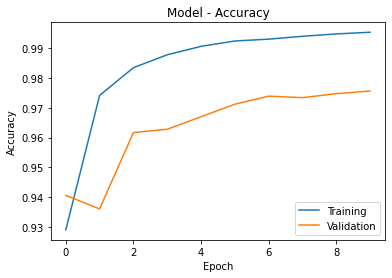

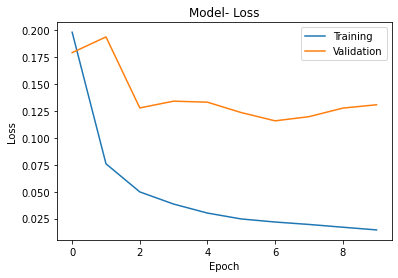

In [18]:
def evaluate_model(history, X_test, y_test):
    
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.show()

evaluate_model(history, X_test, y_test)    

- Dari hasil diatas kita bisa melihat jika akurasi training set = 0.99, sedangkan untuk akurasi validation set = 0.97
- Untuk plot loss training set = 0.01 sedangkan untuk loss validation set = 0.13

In [19]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 10))
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

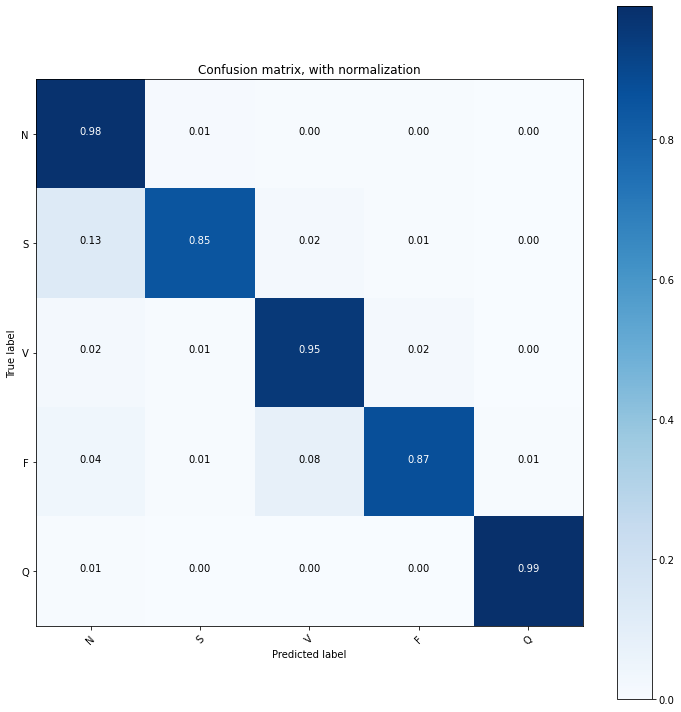

In [20]:
# predict test data
y_pred=model.predict(X_test)


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],normalize=True,
                      title='Confusion matrix, with normalization')


- dari hasil plot confusion matrix, dapat dilihat tiap kelas memiliki banyak TRUE POSITIVE predicted data
- semakin gelap kebiruan menunjukan banyaknya hasil predicted label untuk true label tersebut

In [21]:
print(classification_report(y_test.argmax(axis=1), 
                            y_pred.argmax(axis=1), 
                            target_names=['N', 'S', 'V', 'F', 'Q']))

              precision    recall  f1-score   support

           N       0.99      0.98      0.99     18118
           S       0.69      0.85      0.76       556
           V       0.93      0.95      0.94      1448
           F       0.57      0.87      0.69       162
           Q       0.98      0.99      0.98      1608

    accuracy                           0.97     21892
   macro avg       0.83      0.93      0.87     21892
weighted avg       0.98      0.97      0.98     21892



- Jika kita lihat, nilai report untuk seluruh klas bjuga bagus, 
- Nilai recall dan precission juga tinggi, menunjukan model mampu memprediksi data dengan baik untuk seluruh data pada sclass tersebut 